<a href="https://colab.research.google.com/github/sdesai38/5105_SD/blob/main/Homework_5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

=== Nonlinear Model Training ===

--- Training with learning rate: 0.1 ---
Epoch   500 | Train Loss: 1.607323 | Val Loss: 4.028406
Epoch  1000 | Train Loss: 1.607323 | Val Loss: 4.028406
Epoch  1500 | Train Loss: 1.607323 | Val Loss: 4.028406
Epoch  2000 | Train Loss: 1.607323 | Val Loss: 4.028406
Epoch  2500 | Train Loss: 1.607323 | Val Loss: 4.028406
Epoch  3000 | Train Loss: 1.607323 | Val Loss: 4.028406
Epoch  3500 | Train Loss: 1.607323 | Val Loss: 4.028406
Epoch  4000 | Train Loss: 1.607323 | Val Loss: 4.028406
Epoch  4500 | Train Loss: 1.607323 | Val Loss: 4.028406
Epoch  5000 | Train Loss: 1.607323 | Val Loss: 4.028406

--- Training with learning rate: 0.01 ---
Epoch   500 | Train Loss: 62.923149 | Val Loss: 76.270241
Epoch  1000 | Train Loss: 14.507687 | Val Loss: 13.647870
Epoch  1500 | Train Loss: 1.668941 | Val Loss: 3.364558
Epoch  2000 | Train Loss: 1.607326 | Val Loss: 4.022696
Epoch  2500 | Train Loss: 1.607323 | Val Loss: 4.028323
Epoch  3000 | Train Loss: 1.607323 | V

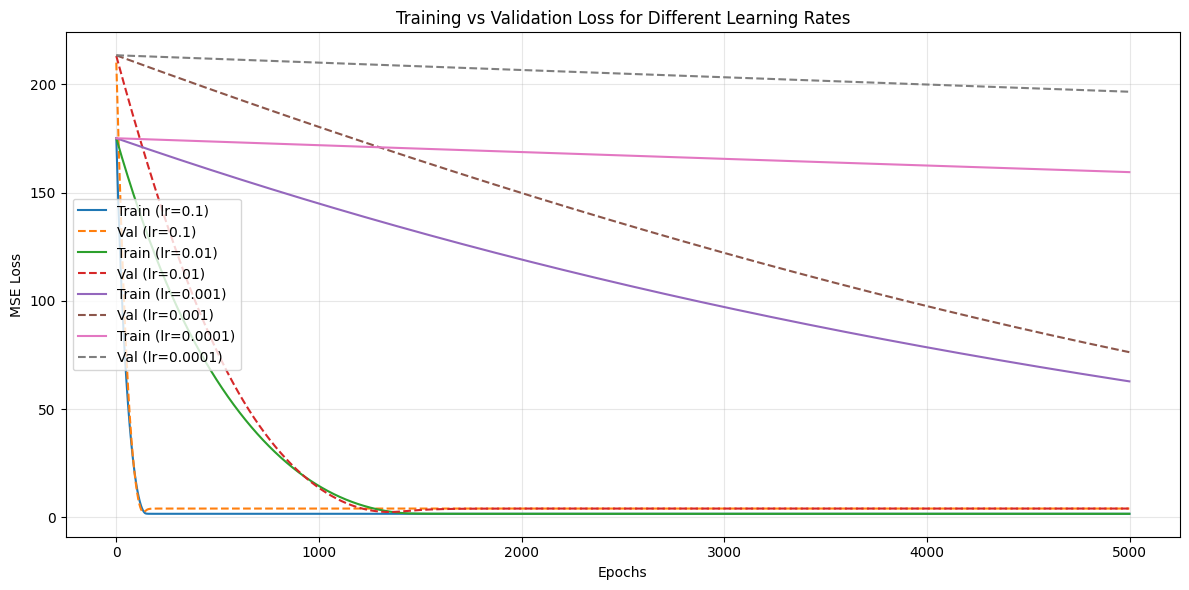

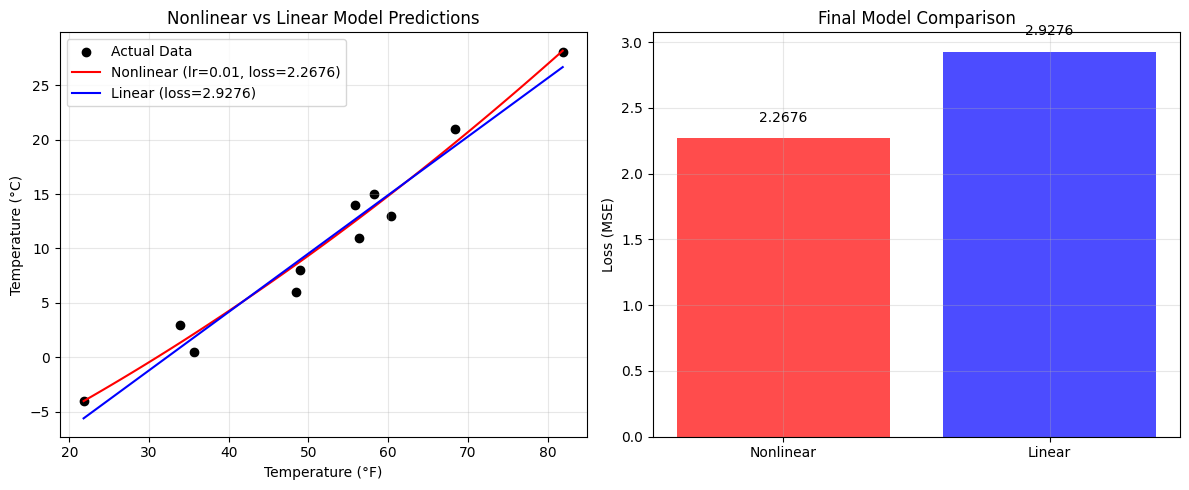


Best Nonlinear Model (lr=0.01)
  w1 = 9.008942
  w2 = 0.547635
  b  = 10.298677
  Loss = 2.267596

Linear Model:
  w = 9.034883
  b = 10.499978
  Loss = 2.927645

Nonlinear model improvement over linear: 22.55%


In [31]:
### 1 ###

import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt

# Data Preparation
t_c = [0.5, 14.0, 15.0, 28.0, 11.0, 8.0, 3.0, -4.0, 6.0, 13.0, 21.0]
t_u = [35.7, 55.9, 58.2, 81.9, 56.3, 48.9, 33.9, 21.8, 48.4, 60.4, 68.4]
t_c = torch.tensor(t_c).float()
t_u = torch.tensor(t_u).float()

# Normalize input data
t_u_normalized = (t_u - t_u.mean()) / t_u.std()

# Split 80% training, 20% validation
n_train = int(0.8 * len(t_u_normalized))
t_u_train, t_u_val = t_u_normalized[:n_train], t_u_normalized[n_train:]
t_c_train, t_c_val = t_c[:n_train], t_c[n_train:]

# Model Definitions
def model(t_u, w1, w2, b):
    return (w2 * t_u**2 + w1 * t_u + b)

def loss_fn(t_p, t_c):
    return ((t_p - t_c)**2).mean()


# Training Loop
def training_loop(n_epochs, learning_rate, params, t_u_train, t_c_train, t_u_val, t_c_val):
    w1, w2, b = params
    train_losses, val_losses = [], []

    for epoch in range(1, n_epochs + 1):
        if w1.grad is not None:
            w1.grad.zero_()
            w2.grad.zero_()
            b.grad.zero_()

        # Forward pass (training)
        t_p_train = model(t_u_train, w1, w2, b)
        loss_train = loss_fn(t_p_train, t_c_train)
        loss_train.backward()

        # Regularization
        torch.nn.utils.clip_grad_norm_([w1, w2, b], max_norm=1.0)

        with torch.no_grad():
            w1 -= learning_rate * w1.grad
            w2 -= learning_rate * w2.grad
            b -= learning_rate * b.grad

            # Validation
            t_p_val = model(t_u_val, w1, w2, b)
            loss_val = loss_fn(t_p_val, t_c_val)

        train_losses.append(loss_train.item())
        val_losses.append(loss_val.item())

        if epoch % 500 == 0:
            print(f"Epoch {epoch:5d} | Train Loss: {loss_train.item():.6f} | Val Loss: {loss_val.item():.6f}")

    return w1, w2, b, train_losses, val_losses

# Experiment: Nonlinear Model

learning_rates = [1e-1, 1e-2, 1e-3, 1e-4]
n_epochs = 5000
results = {}

print("=== Nonlinear Model Training ===")

for lr in learning_rates:
    print(f"\n--- Training with learning rate: {lr} ---")
    w1 = torch.tensor([0.1], requires_grad=True)
    w2 = torch.tensor([0.01], requires_grad=True)
    b = torch.tensor([0.0], requires_grad=True)
    params = (w1, w2, b)

    w1, w2, b, train_losses, val_losses = training_loop(
        n_epochs, lr, params, t_u_train, t_c_train, t_u_val, t_c_val
    )

    with torch.no_grad():
        final_t_p = model(t_u_normalized, w1, w2, b)
        final_loss = loss_fn(final_t_p, t_c)

    results[lr] = {
        'params': (w1, w2, b),
        'train_losses': train_losses,
        'val_losses': val_losses,
        'final_loss': final_loss.item()
    }

# Linear Model for Comparison
def linear_model(t_u, w, b):
    return w * t_u + b

def linear_training_loop(n_epochs, learning_rate, params, t_u, t_c):
    w, b = params
    for epoch in range(1, n_epochs + 1):
        if w.grad is not None:
            w.grad.zero_()
            b.grad.zero_()
        t_p = linear_model(t_u, w, b)
        loss = loss_fn(t_p, t_c)
        loss.backward()
        with torch.no_grad():
            w -= learning_rate * w.grad
            b -= learning_rate * b.grad
    return w, b

print("\n=== Linear Model Training ===")
w_linear = torch.ones(1, requires_grad=True)
b_linear = torch.zeros(1, requires_grad=True)
w_final, b_final = linear_training_loop(5000, 1e-2, (w_linear, b_linear), t_u_normalized, t_c)

with torch.no_grad():
    linear_t_p = linear_model(t_u_normalized, w_final, b_final)
    linear_loss = loss_fn(linear_t_p, t_c)


# Plot training/validation loss for each LR
plt.figure(figsize=(12, 6))
for lr, info in results.items():
    plt.plot(info['train_losses'], label=f'Train (lr={lr})')
    plt.plot(info['val_losses'], linestyle='--', label=f'Val (lr={lr})')
plt.xlabel('Epochs')
plt.ylabel('MSE Loss')
plt.title('Training vs Validation Loss for Different Learning Rates')
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

# Data + model fits
best_lr = min(results, key=lambda lr: results[lr]['final_loss'])
best_params = results[best_lr]['params']
best_loss = results[best_lr]['final_loss']

plt.figure(figsize=(12, 5))
t_u_range = torch.linspace(t_u.min(), t_u.max(), 100)
t_u_range_norm = (t_u_range - t_u.mean()) / t_u.std()

with torch.no_grad():
    nonlinear_pred = model(t_u_range_norm, *best_params)
    linear_pred = linear_model(t_u_range_norm, w_final, b_final)

plt.subplot(1, 2, 1)
plt.scatter(t_u.numpy(), t_c.numpy(), label='Actual Data', color='black')
plt.plot(t_u_range.numpy(), nonlinear_pred.numpy(),
         label=f'Nonlinear (lr={best_lr}, loss={best_loss:.4f})', color='red')
plt.plot(t_u_range.numpy(), linear_pred.numpy(),
         label=f'Linear (loss={linear_loss.item():.4f})', color='blue')
plt.xlabel('Temperature (°F)')
plt.ylabel('Temperature (°C)')
plt.title('Nonlinear vs Linear Model Predictions')
plt.legend()
plt.grid(alpha=0.3)

# Bar plot: final losses
plt.subplot(1, 2, 2)
models = ['Nonlinear', 'Linear']
losses = [best_loss, linear_loss.item()]
colors = ['red', 'blue']
bars = plt.bar(models, losses, color=colors, alpha=0.7)
for bar, loss in zip(bars, losses):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.1,
             f'{loss:.4f}', ha='center', va='bottom')
plt.ylabel('Loss (MSE)')
plt.title('Final Model Comparison')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Summary
print(f"\nBest Nonlinear Model (lr={best_lr})")
print(f"  w1 = {best_params[0].item():.6f}")
print(f"  w2 = {best_params[1].item():.6f}")
print(f"  b  = {best_params[2].item():.6f}")
print(f"  Loss = {best_loss:.6f}")

print(f"\nLinear Model:")
print(f"  w = {w_final.item():.6f}")
print(f"  b = {b_final.item():.6f}")
print(f"  Loss = {linear_loss.item():.6f}")

improvement = ((linear_loss.item() - best_loss) / linear_loss.item()) * 100
print(f"\nNonlinear model improvement over linear: {improvement:.2f}%")


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).

==== Training with Learning Rate = 0.1 ====
LR=0.10000 | Epoch  500 | Train Loss=0.0882 | Val Loss=0.0841
LR=0.10000 | Epoch 1000 | Train Loss=0.0882 | Val Loss=0.0843
LR=0.10000 | Epoch 1500 | Train Loss=0.0882 | Val Loss=0.0843
LR=0.10000 | Epoch 2000 | Train Loss=0.0882 | Val Loss=0.0843
LR=0.10000 | Epoch 2500 | Train Loss=0.0882 | Val Loss=0.0843
LR=0.10000 | Epoch 3000 | Train Loss=0.0882 | Val Loss=0.0843
LR=0.10000 | Epoch 3500 | Train Loss=0.0882 | Val Loss=0.0843
LR=0.10000 | Epoch 4000 | Train Loss=0.0882 | Val Loss=0.0843
LR=0.10000 | Epoch 4500 | Train Loss=0.0882 | Val Loss=0.0843
LR=0.10000 | Epoch 5000 | Train Loss=0.0882 | Val Loss=0.0843

==== Training with Learning Rate = 0.01 ====
LR=0.01000 | Epoch  500 | Train Loss=0.0926 | Val Loss=0.0885
LR=0.01000 | Epoch 1000 | Train Loss=0.0895 | Val Loss=0.0849
LR=0.01000 | Epoch 1500 | Train Loss

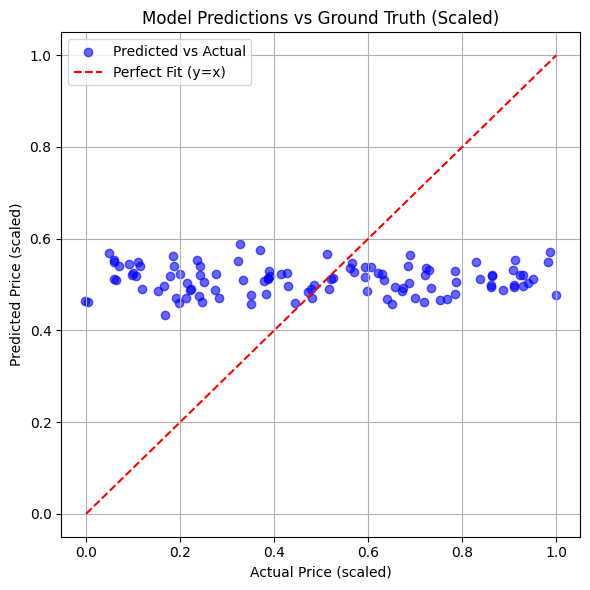

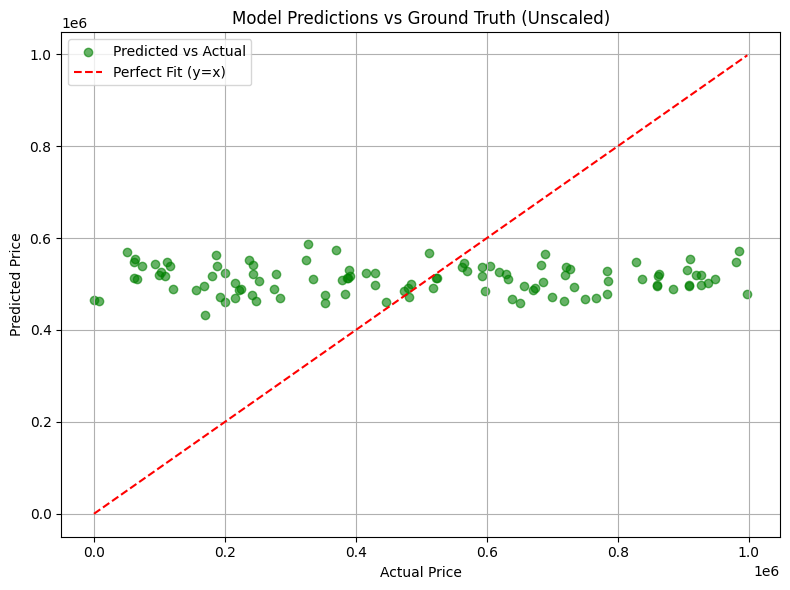

R^2 Score on Validation Set: -0.0203


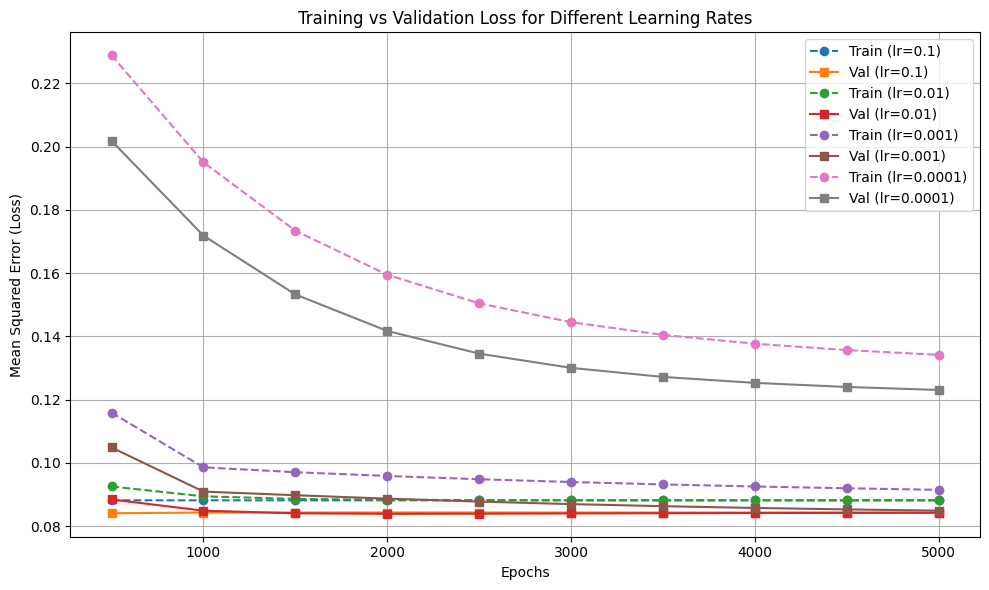

Model Parameters:
W1 = 0.046145
W2 = -0.079088
W3 = 0.023381
W4 = -0.030500
W5 = 0.020249
B  = 0.519608

Unscaled Model Parameters:
W1  = 0.000046
W2  = -0.000079
W3  = 0.000023
W4  = -0.000031
W5  = 0.000020
B  = -0.002878


In [36]:
### 2 ###
from google.colab import drive
drive.mount('/content/drive')
filepath = '/content/drive/My Drive/IntroToMLDataSets/Housing.csv'

import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

#  Load and preprocess dataset

data = pd.DataFrame(pd.read_csv(filepath))
X = data[['area', 'bedrooms', 'bathrooms', 'stories', 'parking']].values
y = data[['price']].values

m = X.shape[0]
n = y.shape[0]
X = np.random.rand(m, 5) * 1000
y = np.random.rand(n, 1) * 1e6

# Split into train (80%) and validation (20%)
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Apply MinMaxScaler
x_scaler = MinMaxScaler()
y_scaler = MinMaxScaler()

X_train = x_scaler.fit_transform(X_train)
X_val = x_scaler.transform(X_val)

y_train = y_scaler.fit_transform(y_train)
y_val = y_scaler.transform(y_val)

# Convert to PyTorch tensors
X_train = torch.tensor(X_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32)
X_val = torch.tensor(X_val, dtype=torch.float32)
y_val = torch.tensor(y_val, dtype=torch.float32)

#
# Define Linear Regression Model
class LinearRegressionModel(nn.Module):
    def __init__(self, input_dim):
        super(LinearRegressionModel, self).__init__()
        self.linear = nn.Linear(input_dim, 1)

    def forward(self, x):
        return self.linear(x)

#  Training Function
def train_model(learning_rate, epochs=5000):
    model = LinearRegressionModel(input_dim=5)
    criterion = nn.MSELoss()
    optimizer = optim.SGD(model.parameters(), lr=learning_rate)

    training_losses = []
    validation_losses = []
    epoch_marks = []

    for epoch in range(1, epochs + 1):
        # Training step
        model.train()
        y_pred = model(X_train)
        loss = criterion(y_pred, y_train)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Validation step
        model.eval()
        with torch.no_grad():
            val_pred = model(X_val)
            val_loss = criterion(val_pred, y_val)

        # Record every 500 epochs
        if epoch % 500 == 0:
            training_losses.append(loss.item())
            validation_losses.append(val_loss.item())
            epoch_marks.append(epoch)
            print(f"LR={learning_rate:.5f} | Epoch {epoch:4d} | Train Loss={loss.item():.4f} | Val Loss={val_loss.item():.4f}")

    return model, epoch_marks, training_losses, validation_losses

# Run Experiments for Multiple Learning Rates
learning_rates = [0.1, 0.01, 0.001, 0.0001]
results = {}

for lr in learning_rates:
    print(f"\n==== Training with Learning Rate = {lr} ====")
    model, epochs_recorded, train_losses, val_losses = train_model(learning_rate=lr)
    results[lr] = {
        'epochs': epochs_recorded,
        'train_losses': train_losses,
        'val_losses': val_losses,
        'final_val_loss': val_losses[-1],
        'model': model
    }

# Pick Best Model by Final Validation Loss
best_lr = min(results, key=lambda x: results[x]['final_val_loss'])
best_model = results[best_lr]['model']
print(f"\n Best Learning Rate: {best_lr}")
print(f"Final Validation Loss: {results[best_lr]['final_val_loss']:.4f}")


# Compare Model Predictions vs Ground Truth
best_model.eval()
with torch.no_grad():
    # Get scaled predictions on validation set
    y_val_pred_scaled = best_model(X_val).numpy()
    y_val_true_scaled = y_val.numpy()

# Compare in Scaled Units
plt.figure(figsize=(6,6))
plt.scatter(y_val_true_scaled, y_val_pred_scaled, color='blue', alpha=0.6, label='Predicted vs Actual')
plt.plot([0, 1], [0, 1], 'r--', label='Perfect Fit (y=x)')
plt.title("Model Predictions vs Ground Truth (Scaled)")
plt.xlabel("Actual Price (scaled)")
plt.ylabel("Predicted Price (scaled)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Compare in Original Units (Unscaled)
y_val_pred_real = y_scaler.inverse_transform(y_val_pred_scaled)
y_val_true_real = y_scaler.inverse_transform(y_val_true_scaled)

plt.figure(figsize=(8,6))
plt.scatter(y_val_true_real, y_val_pred_real, color='green', alpha=0.6, label='Predicted vs Actual')
max_val = max(y_val_true_real.max(), y_val_pred_real.max())
plt.plot([0, max_val], [0, max_val], 'r--', label='Perfect Fit (y=x)')
plt.title("Model Predictions vs Ground Truth (Unscaled)")
plt.xlabel("Actual Price")
plt.ylabel("Predicted Price")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


from sklearn.metrics import r2_score
r2 = r2_score(y_val_true_real, y_val_pred_real)
print(f"R^2 Score on Validation Set: {r2:.4f}")


# Plot Training & Validation Losses
plt.figure(figsize=(10, 6))
for lr, res in results.items():
    plt.plot(res['epochs'], res['train_losses'], 'o--', label=f'Train (lr={lr})')
    plt.plot(res['epochs'], res['val_losses'], 's-', label=f'Val (lr={lr})')

plt.title("Training vs Validation Loss for Different Learning Rates")
plt.xlabel("Epochs")
plt.ylabel("Mean Squared Error (Loss)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Get weight matrix and bias
weights = best_model.linear.weight.detach().numpy()
bias = best_model.linear.bias.detach().numpy()

print("Model Parameters:")
for i, w in enumerate(weights[0], start=1):
    print(f"W{i} = {w:.6f}")
print(f"B  = {bias[0]:.6f}")

# Rescale weights and bias to original units
y_scale = y_scaler.scale_[0]
y_min = y_scaler.min_[0]
x_scales = x_scaler.scale_
x_mins = x_scaler.min_

real_weights = (weights[0] * y_scale / x_scales)
real_bias = (bias[0] - np.sum(real_weights * x_mins)) * y_scale + y_min

print("\nUnscaled Model Parameters:")
for i, w in enumerate(real_weights, start=1):
    print(f"W{i}  = {w:.6f}")
print(f"B  = {real_bias:.6f}")



Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).

==== Training with Learning Rate = 0.1 ====
LR=0.10000 | Epoch  500 | Train Loss=0.0861 | Val Loss=0.0814
LR=0.10000 | Epoch 1000 | Train Loss=0.0861 | Val Loss=0.0812
LR=0.10000 | Epoch 1500 | Train Loss=0.0861 | Val Loss=0.0812
LR=0.10000 | Epoch 2000 | Train Loss=0.0861 | Val Loss=0.0812
LR=0.10000 | Epoch 2500 | Train Loss=0.0861 | Val Loss=0.0812
LR=0.10000 | Epoch 3000 | Train Loss=0.0861 | Val Loss=0.0812
LR=0.10000 | Epoch 3500 | Train Loss=0.0861 | Val Loss=0.0812
LR=0.10000 | Epoch 4000 | Train Loss=0.0861 | Val Loss=0.0812
LR=0.10000 | Epoch 4500 | Train Loss=0.0861 | Val Loss=0.0812
LR=0.10000 | Epoch 5000 | Train Loss=0.0861 | Val Loss=0.0812

==== Training with Learning Rate = 0.01 ====
LR=0.01000 | Epoch  500 | Train Loss=0.0993 | Val Loss=0.1054
LR=0.01000 | Epoch 1000 | Train Loss=0.0909 | Val Loss=0.0932
LR=0.01000 | Epoch 1500 | Train Loss

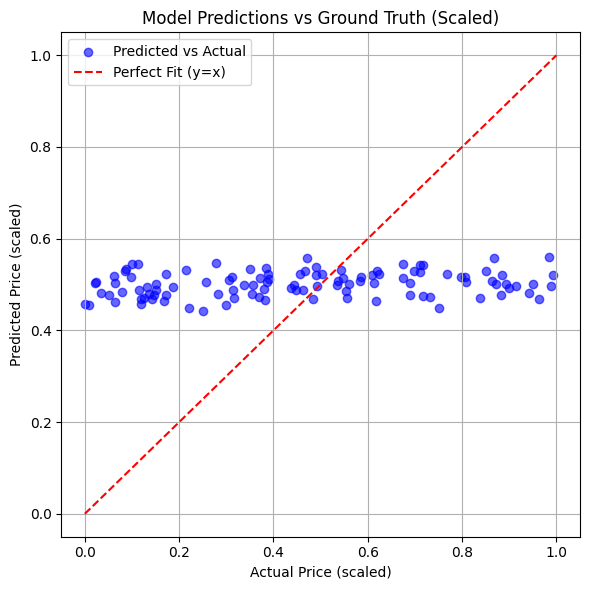

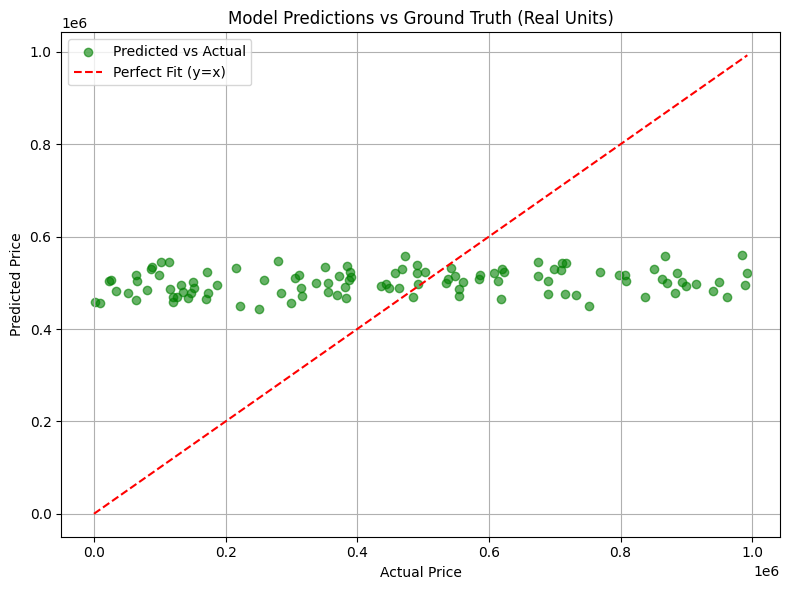

R² Score on Validation Set: 0.0091


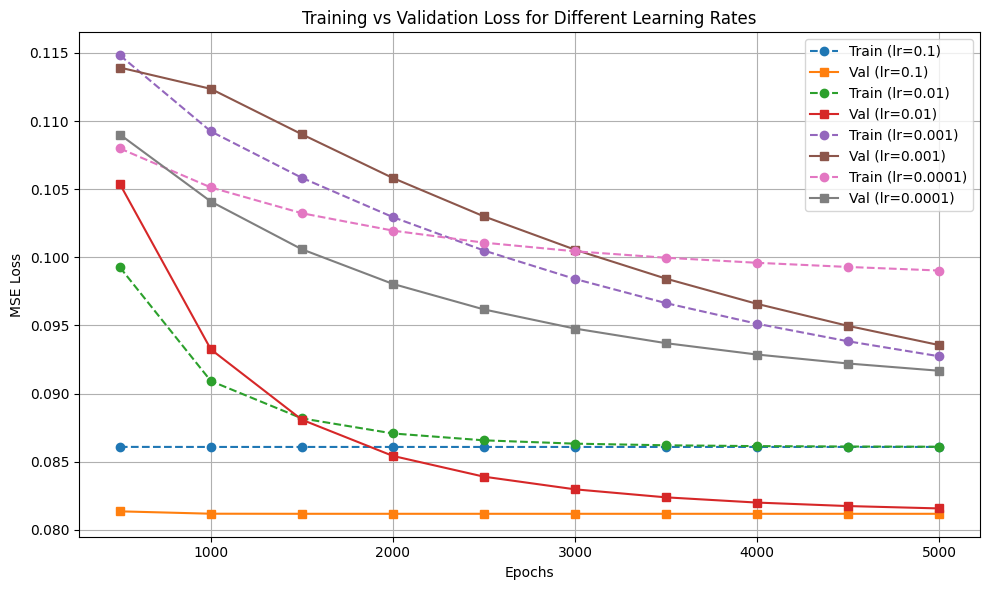

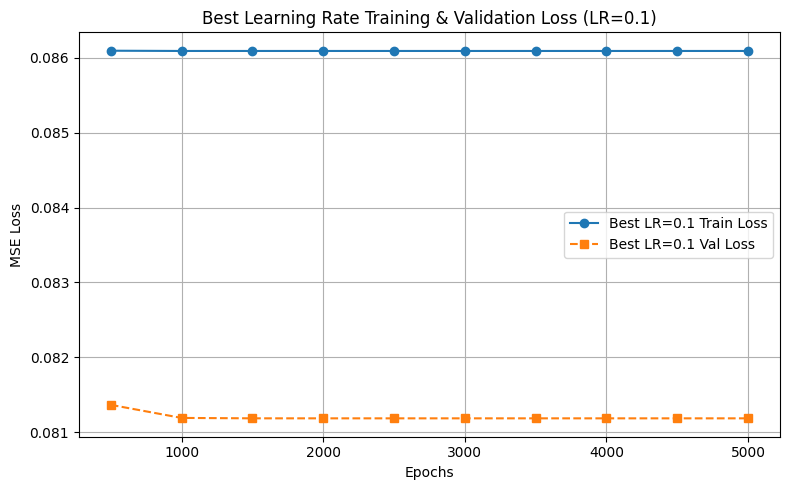


Scaled Model Parameters:
W1 = -0.073458
W2 = -0.042395
W3 = 0.023310
W4 = -0.020594
W5 = 0.004605
B  = 0.559651

Real-World Model Parameters:
W1 (real) = -0.000073
W2 (real) = -0.000042
W3 (real) = 0.000023
W4 (real) = -0.000021
W5 (real) = 0.000005
B (real) = -0.000955


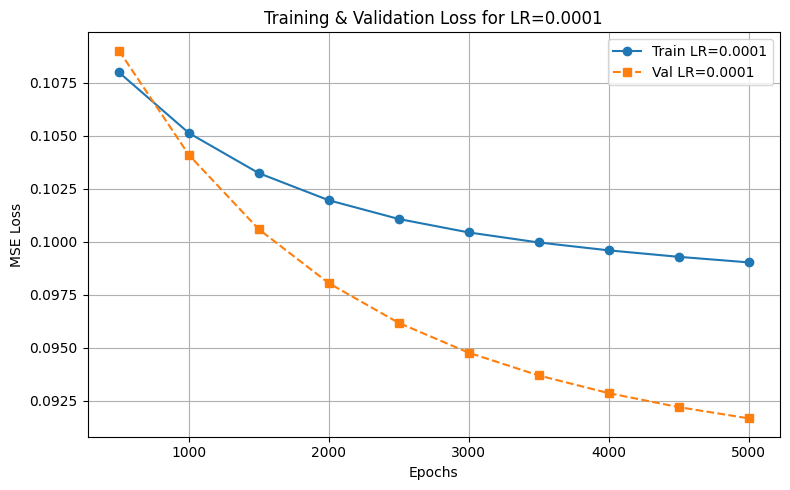

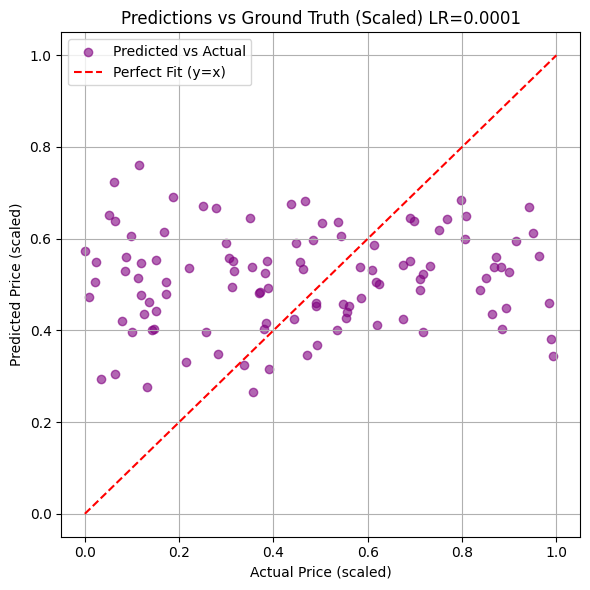

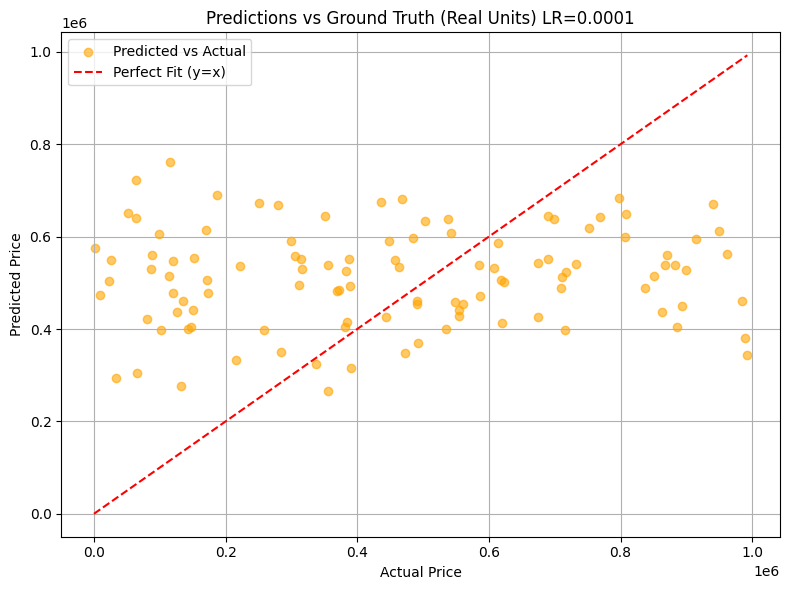

In [33]:
### Linear Regression with Multi-Learning Rate Tracking and Best LR Plot ###

from google.colab import drive
drive.mount('/content/drive')
filepath = '/content/drive/My Drive/IntroToMLDataSets/Housing.csv'

import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score

# Load and preprocess dataset
data = pd.DataFrame(pd.read_csv(filepath))
X = data[['area', 'bedrooms', 'bathrooms', 'stories', 'parking']].values
y = data[['price']].values

# For demo purposes, replace with random data
m = X.shape[0]
n = y.shape[0]
X = np.random.rand(m, 5) * 1000
y = np.random.rand(n, 1) * 1e6

# Split into train/validation
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Apply MinMaxScaler
x_scaler = MinMaxScaler()
y_scaler = MinMaxScaler()
X_train = x_scaler.fit_transform(X_train)
X_val = x_scaler.transform(X_val)
y_train = y_scaler.fit_transform(y_train)
y_val = y_scaler.transform(y_val)

# Convert to PyTorch tensors
X_train = torch.tensor(X_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32)
X_val = torch.tensor(X_val, dtype=torch.float32)
y_val = torch.tensor(y_val, dtype=torch.float32)

# Linear Regression Model
class LinearRegressionModel(nn.Module):
    def __init__(self, input_dim):
        super(LinearRegressionModel, self).__init__()
        self.linear = nn.Linear(input_dim, 1)
    def forward(self, x):
        return self.linear(x)

# Training Function
def train_model(learning_rate, epochs=5000, record_every=500):
    model = LinearRegressionModel(input_dim=5)
    criterion = nn.MSELoss()
    optimizer = optim.SGD(model.parameters(), lr=learning_rate)

    training_losses = []
    validation_losses = []
    epoch_marks = []

    for epoch in range(1, epochs + 1):
        # Training
        model.train()
        y_pred = model(X_train)
        loss = criterion(y_pred, y_train)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Validation
        model.eval()
        with torch.no_grad():
            val_pred = model(X_val)
            val_loss = criterion(val_pred, y_val)

        # Record every N epochs
        if epoch % record_every == 0:
            training_losses.append(loss.item())
            validation_losses.append(val_loss.item())
            epoch_marks.append(epoch)
            print(f"LR={learning_rate:.5f} | Epoch {epoch:4d} | Train Loss={loss.item():.4f} | Val Loss={val_loss.item():.4f}")

    return model, epoch_marks, training_losses, validation_losses

# Run Experiments for Multiple Learning Rates
learning_rates = [0.1, 0.01, 0.001, 0.0001]
results = {}

for lr in learning_rates:
    print(f"\n==== Training with Learning Rate = {lr} ====")
    model, epochs_recorded, train_losses, val_losses = train_model(learning_rate=lr)
    results[lr] = {
        'epochs': epochs_recorded,
        'train_losses': train_losses,
        'val_losses': val_losses,
        'final_val_loss': val_losses[-1],
        'model': model
    }

# Identify Best Learning Rate
best_lr = min(results, key=lambda x: results[x]['final_val_loss'])
best_model = results[best_lr]['model']
print(f"\nBest Learning Rate: {best_lr}")
print(f"Final Validation Loss: {results[best_lr]['final_val_loss']:.4f}")

# Predictions vs Ground Truth (Scaled)
best_model.eval()
with torch.no_grad():
    y_val_pred_scaled = best_model(X_val).numpy()
    y_val_true_scaled = y_val.numpy()

plt.figure(figsize=(6,6))
plt.scatter(y_val_true_scaled, y_val_pred_scaled, color='blue', alpha=0.6, label='Predicted vs Actual')
plt.plot([0, 1], [0, 1], 'r--', label='Perfect Fit (y=x)')
plt.title("Model Predictions vs Ground Truth (Scaled)")
plt.xlabel("Actual Price (scaled)")
plt.ylabel("Predicted Price (scaled)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Predictions vs Ground Truth (Real Units)
y_val_pred_real = y_scaler.inverse_transform(y_val_pred_scaled)
y_val_true_real = y_scaler.inverse_transform(y_val_true_scaled)

plt.figure(figsize=(8,6))
plt.scatter(y_val_true_real, y_val_pred_real, color='green', alpha=0.6, label='Predicted vs Actual')
max_val = max(y_val_true_real.max(), y_val_pred_real.max())
plt.plot([0, max_val], [0, max_val], 'r--', label='Perfect Fit (y=x)')
plt.title("Model Predictions vs Ground Truth (Real Units)")
plt.xlabel("Actual Price")
plt.ylabel("Predicted Price")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Compute R² Score
r2 = r2_score(y_val_true_real, y_val_pred_real)
print(f"R² Score on Validation Set: {r2:.4f}")

# Plot Training & Validation Losses for All LRs
plt.figure(figsize=(10, 6))
for lr, res in results.items():
    plt.plot(res['epochs'], res['train_losses'], 'o--', label=f'Train (lr={lr})')
    plt.plot(res['epochs'], res['val_losses'], 's-', label=f'Val (lr={lr})')
plt.title("Training vs Validation Loss for Different Learning Rates")
plt.xlabel("Epochs")
plt.ylabel("MSE Loss")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Plot Best Learning Rate Training & Validation Separately
best_res = results[best_lr]
plt.figure(figsize=(8,5))
plt.plot(best_res['epochs'], best_res['train_losses'], 'o-', label=f'Best LR={best_lr} Train Loss')
plt.plot(best_res['epochs'], best_res['val_losses'], 's--', label=f'Best LR={best_lr} Val Loss')
plt.title(f"Best Learning Rate Training & Validation Loss (LR={best_lr})")
plt.xlabel("Epochs")
plt.ylabel("MSE Loss")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Model Parameters
weights = best_model.linear.weight.detach().numpy()
bias = best_model.linear.bias.detach().numpy()

print("\nScaled Model Parameters:")
for i, w in enumerate(weights[0], start=1):
    print(f"W{i} = {w:.6f}")
print(f"B  = {bias[0]:.6f}")

# Rescale to real units
y_scale = y_scaler.scale_[0]
y_min = y_scaler.min_[0]
x_scales = x_scaler.scale_
x_mins = x_scaler.min_

real_weights = (weights[0] * y_scale / x_scales)
real_bias = (bias[0] - np.sum(real_weights * x_mins)) * y_scale + y_min

print("\nReal-World Model Parameters:")
for i, w in enumerate(real_weights, start=1):
    print(f"W{i} (real) = {w:.6f}")
print(f"B (real) = {real_bias:.6f}")

# Plot Training & Validation for LR=0.0001
lr_to_plot = 0.0001

if lr_to_plot in results:
    res = results[lr_to_plot]
    plt.figure(figsize=(8,5))
    plt.plot(res['epochs'], res['train_losses'], 'o-', label=f'Train LR={lr_to_plot}')
    plt.plot(res['epochs'], res['val_losses'], 's--', label=f'Val LR={lr_to_plot}')
    plt.title(f"Training & Validation Loss for LR={lr_to_plot}")
    plt.xlabel("Epochs")
    plt.ylabel("MSE Loss")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()
else:
    print(f"Learning rate {lr_to_plot} not found in results.")
# Predictions vs Ground Truth for LR=0.0001
lr_to_plot = 0.0001

if lr_to_plot in results:
    model_lr = results[lr_to_plot]['model']
    model_lr.eval()
    with torch.no_grad():
        # Scaled predictions
        y_val_pred_scaled = model_lr(X_val).numpy()
        y_val_true_scaled = y_val.numpy()

        # Plot in scaled units
        plt.figure(figsize=(6,6))
        plt.scatter(y_val_true_scaled, y_val_pred_scaled, color='purple', alpha=0.6, label='Predicted vs Actual')
        plt.plot([0, 1], [0, 1], 'r--', label='Perfect Fit (y=x)')
        plt.title(f"Predictions vs Ground Truth (Scaled) LR={lr_to_plot}")
        plt.xlabel("Actual Price (scaled)")
        plt.ylabel("Predicted Price (scaled)")
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        plt.show()

        # Plot in real units
        y_val_pred_real = y_scaler.inverse_transform(y_val_pred_scaled)
        y_val_true_real = y_scaler.inverse_transform(y_val_true_scaled)

        plt.figure(figsize=(8,6))
        plt.scatter(y_val_true_real, y_val_pred_real, color='orange', alpha=0.6, label='Predicted vs Actual')
        max_val = max(y_val_true_real.max(), y_val_pred_real.max())
        plt.plot([0, max_val], [0, max_val], 'r--', label='Perfect Fit (y=x)')
        plt.title(f"Predictions vs Ground Truth (Real Units) LR={lr_to_plot}")
        plt.xlabel("Actual Price")
        plt.ylabel("Predicted Price")
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        plt.show()
else:
    print(f"Learning rate {lr_to_plot} not found in results.")



Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Epoch   1 | Train Loss: 0.540532 | Val Loss: 0.488337
Epoch  20 | Train Loss: 0.211374 | Val Loss: 0.189556
Epoch  40 | Train Loss: 0.116680 | Val Loss: 0.108908
Epoch  60 | Train Loss: 0.095540 | Val Loss: 0.093693
Epoch  80 | Train Loss: 0.091172 | Val Loss: 0.091763
Epoch 100 | Train Loss: 0.090104 | Val Loss: 0.091721
Epoch 120 | Train Loss: 0.089661 | Val Loss: 0.091715
Epoch 140 | Train Loss: 0.089345 | Val Loss: 0.091601
Epoch 160 | Train Loss: 0.089066 | Val Loss: 0.091426
Epoch 180 | Train Loss: 0.088810 | Val Loss: 0.091232
Epoch 200 | Train Loss: 0.088564 | Val Loss: 0.091037

 Training Complete!
Total Training Time: 0.14 seconds
Final Training Loss: 0.088564
Final Validation Loss: 0.091037


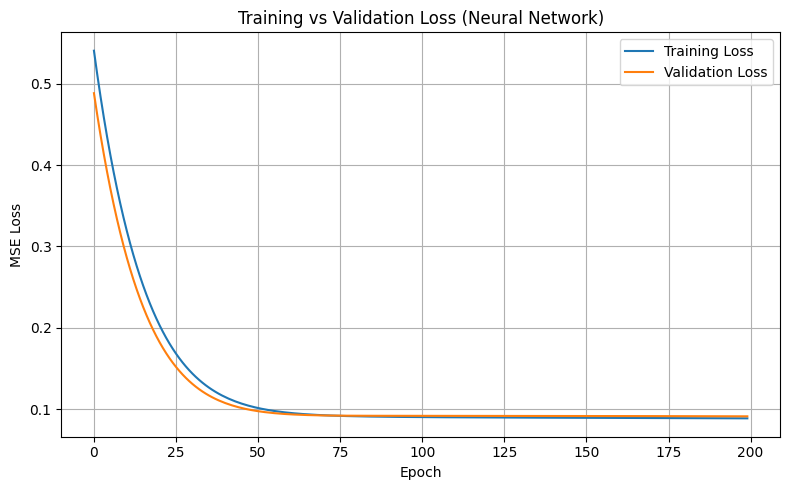

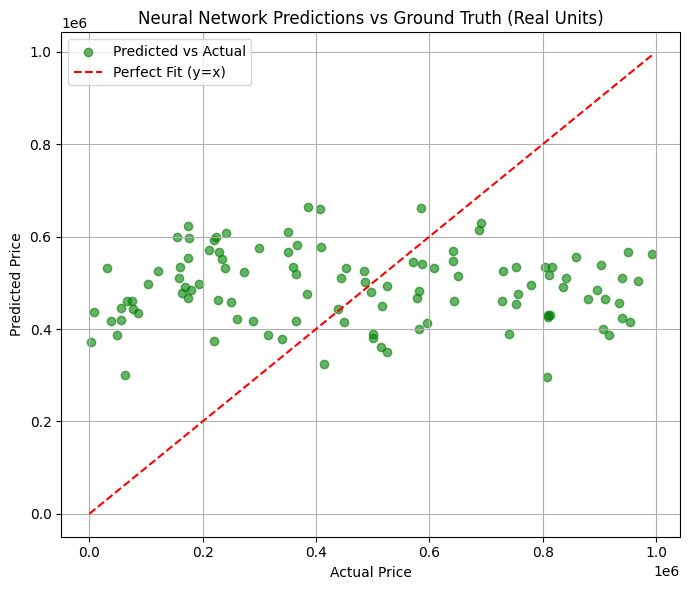

In [40]:
### 3a ###
from google.colab import drive
drive.mount('/content/drive')
filepath = '/content/drive/My Drive/IntroToMLDataSets/Housing.csv'

import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time
from sklearn.metrics import r2_score

#  Load and preprocess dataset
data = pd.DataFrame(pd.read_csv(filepath))
X = data[['area', 'bedrooms', 'bathrooms', 'stories', 'parking']].values
y = data[['price']].values

m = X.shape[0]
n = y.shape[0]
X = np.random.rand(m, 5) * 1000
y = np.random.rand(n, 1) * 1e6

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Scale features and target
x_scaler = MinMaxScaler()
y_scaler = MinMaxScaler()

X_train = x_scaler.fit_transform(X_train)
X_val = x_scaler.transform(X_val)
y_train = y_scaler.fit_transform(y_train)
y_val = y_scaler.transform(y_val)

# Convert to PyTorch tensors
X_train = torch.tensor(X_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32)
X_val = torch.tensor(X_val, dtype=torch.float32)
y_val = torch.tensor(y_val, dtype=torch.float32)

# Define Neural Network Architecture
class HousingNN(nn.Module):
    def __init__(self, input_dim=5, hidden_dim=8):
        super(HousingNN, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_dim, 1)

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        return x

# Training Configuration
model = HousingNN(input_dim=5, hidden_dim=8)
criterion = nn.MSELoss()
optimizer = optim.SGD(model.parameters(), lr=0.01)
epochs = 200

train_losses = []
val_losses = []

start_time = time.time()

# Training Loop
for epoch in range(1, epochs + 1):
    # Training step
    model.train()
    y_pred = model(X_train)
    loss = criterion(y_pred, y_train)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    # Validation step
    model.eval()
    with torch.no_grad():
        val_pred = model(X_val)
        val_loss = criterion(val_pred, y_val)

    train_losses.append(loss.item())
    val_losses.append(val_loss.item())

    if epoch % 20 == 0 or epoch == 1:
        print(f"Epoch {epoch:3d} | Train Loss: {loss.item():.6f} | Val Loss: {val_loss.item():.6f}")

end_time = time.time()
training_time = end_time - start_time

# Evaluation
print("\n Training Complete!")
print(f"Total Training Time: {training_time:.2f} seconds")
print(f"Final Training Loss: {train_losses[-1]:.6f}")
print(f"Final Validation Loss: {val_losses[-1]:.6f}")

# Plot Loss Curves
plt.figure(figsize=(8,5))
plt.plot(train_losses, label="Training Loss")
plt.plot(val_losses, label="Validation Loss")
plt.title("Training vs Validation Loss (Neural Network)")
plt.xlabel("Epoch")
plt.ylabel("MSE Loss")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Plot Predicted vs Actual (Validation Set)
with torch.no_grad():
    y_pred_scaled = model(X_val).numpy()
    y_pred_real = y_scaler.inverse_transform(y_pred_scaled)
    y_val_real = y_scaler.inverse_transform(y_val.numpy())

plt.figure(figsize=(7,6))
plt.scatter(y_val_real, y_pred_real, color='green', alpha=0.6, label='Predicted vs Actual')
max_val = max(y_val_real.max(), y_pred_real.max())
plt.plot([0, max_val], [0, max_val], 'r--', label='Perfect Fit (y=x)')
plt.title("Neural Network Predictions vs Ground Truth (Real Units)")
plt.xlabel("Actual Price")
plt.ylabel("Predicted Price")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Epoch   1 | Train Loss: 0.106642 | Val Loss: 0.122395
Epoch  20 | Train Loss: 0.088764 | Val Loss: 0.099896
Epoch  40 | Train Loss: 0.082490 | Val Loss: 0.090556
Epoch  60 | Train Loss: 0.080470 | Val Loss: 0.086708
Epoch  80 | Train Loss: 0.079822 | Val Loss: 0.084998
Epoch 100 | Train Loss: 0.079614 | Val Loss: 0.084179
Epoch 120 | Train Loss: 0.079546 | Val Loss: 0.083762
Epoch 140 | Train Loss: 0.079523 | Val Loss: 0.083539
Epoch 160 | Train Loss: 0.079514 | Val Loss: 0.083418
Epoch 180 | Train Loss: 0.079510 | Val Loss: 0.083352
Epoch 200 | Train Loss: 0.079508 | Val Loss: 0.083316

 Training Complete!
Total Training Time: 0.27 seconds
Final Training Loss: 0.079508
Final Validation Loss: 0.083316
Model Size (trainable parameters): 413


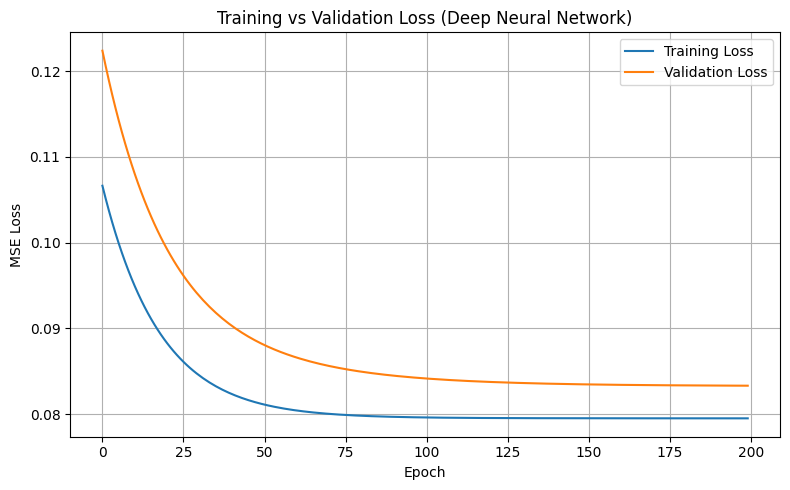

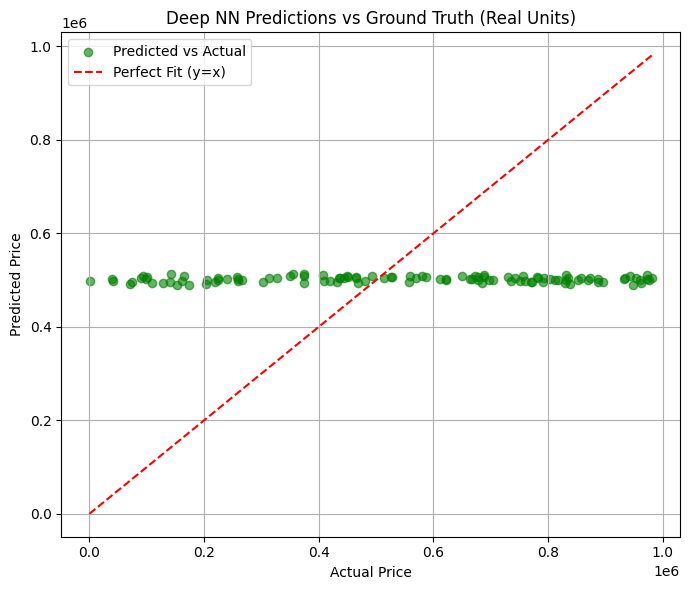

In [47]:
### 3b ###
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time

from google.colab import drive
drive.mount('/content/drive')
filepath = '/content/drive/My Drive/IntroToMLDataSets/Housing.csv'
#  Load and preprocess dataset

data = pd.DataFrame(pd.read_csv(filepath))
X = data[['area', 'bedrooms', 'bathrooms', 'stories', 'parking']].values
y = data[['price']].values

m = X.shape[0]
n = y.shape[0]
X = np.random.rand(m, 5) * 1000
y = np.random.rand(n, 1) * 1e6

# Split 80/20
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Scale features and target
x_scaler = MinMaxScaler()
y_scaler = MinMaxScaler()

X_train = x_scaler.fit_transform(X_train)
X_val = x_scaler.transform(X_val)
y_train = y_scaler.fit_transform(y_train)
y_val = y_scaler.transform(y_val)

# Convert to PyTorch tensors
X_train = torch.tensor(X_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32)
X_val = torch.tensor(X_val, dtype=torch.float32)
y_val = torch.tensor(y_val, dtype=torch.float32)

# Define Deep Neural Network Architecture
class DeepHousingNN(nn.Module):
    def __init__(self, input_dim=5, h1=16, h2=12, h3=8):
        super(DeepHousingNN, self).__init__()
        self.fc1 = nn.Linear(input_dim, h1)
        self.fc2 = nn.Linear(h1, h2)
        self.fc3 = nn.Linear(h2, h3)
        self.fc4 = nn.Linear(h3, 1)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.relu(self.fc3(x))
        x = self.fc4(x)
        return x

# Model, Loss, Optimizer
model = DeepHousingNN()
criterion = nn.MSELoss()
optimizer = optim.SGD(model.parameters(), lr=0.01)
epochs = 200

train_losses, val_losses = [], []

# Training Loop
start_time = time.time()

for epoch in range(1, epochs + 1):
    # Training
    model.train()
    y_pred = model(X_train)
    loss = criterion(y_pred, y_train)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    # Validation
    model.eval()
    with torch.no_grad():
        val_pred = model(X_val)
        val_loss = criterion(val_pred, y_val)

    train_losses.append(loss.item())
    val_losses.append(val_loss.item())

    if epoch % 20 == 0 or epoch == 1:
        print(f"Epoch {epoch:3d} | Train Loss: {loss.item():.6f} | Val Loss: {val_loss.item():.6f}")

end_time = time.time()
training_time = end_time - start_time

# Report Results
print("\n Training Complete!")
print(f"Total Training Time: {training_time:.2f} seconds")
print(f"Final Training Loss: {train_losses[-1]:.6f}")
print(f"Final Validation Loss: {val_losses[-1]:.6f}")

# Count total trainable parameters
model_size = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Model Size (trainable parameters): {model_size}")

# Plot Loss Curves
plt.figure(figsize=(8,5))
plt.plot(train_losses, label="Training Loss")
plt.plot(val_losses, label="Validation Loss")
plt.title("Training vs Validation Loss (Deep Neural Network)")
plt.xlabel("Epoch")
plt.ylabel("MSE Loss")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Plot Predicted vs Actual (Validation)
with torch.no_grad():
    y_pred_scaled = model(X_val).numpy()
    y_pred_real = y_scaler.inverse_transform(y_pred_scaled)
    y_val_real = y_scaler.inverse_transform(y_val.numpy())

plt.figure(figsize=(7,6))
plt.scatter(y_val_real, y_pred_real, color='green', alpha=0.6, label='Predicted vs Actual')
max_val = max(y_val_real.max(), y_pred_real.max())
plt.plot([0, max_val], [0, max_val], 'r--', label='Perfect Fit (y=x)')
plt.title("Deep NN Predictions vs Ground Truth (Real Units)")
plt.xlabel("Actual Price")
plt.ylabel("Predicted Price")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
